# CS231: Computer Vision 
## Final Project: Traffic sign classification ##


# Import Libraries #

In [95]:
import os
import random
import numpy as np 
import pandas as pd 
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import joblib
import pickle

# Data Loading #

In [14]:
base_dir = "./data/traffic_Data/"
train_dir = base_dir + "/DATA/"
class_dirs = ["3", "5", "11", "16", "24", "26", "28", "30", "54", "55"]

In [15]:
image_paths = []
for cls in class_dirs:
    for file_name in os.listdir(train_dir+cls):
        if file_name.split('.')[-1] == 'png':
            image_paths.append(os.path.join(train_dir, cls, file_name))

print("Total image =", len(image_paths))

Total image = 1387


In [16]:
classes = []

for image_path in image_paths:
    classes.append(image_path.split('/')[-2])

In [17]:
print(classes)

['3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5',

# Data Preprocessing #

In [18]:
img_ls = []
for i in image_paths:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    img_ls.append(img)

In [19]:
le = LabelEncoder()
y = le.fit_transform(classes)
y = np.array(y)
print(y)

[5 5 5 ... 9 9 9]


In [20]:
unique_classes = np.unique(y)
print(unique_classes)
class_indices = {class_id: np.where(y == class_id)[0] for class_id in unique_classes}
print(class_indices[7])

[0 1 2 3 4 5 6 7 8 9]
[139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156
 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174
 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282
 283 284 285 286 287 288]


In [47]:
# ploting total samples for each class
labels = pd.read_csv('./data/labels.csv')

class_names = []

class_id = le.inverse_transform(unique_classes)
for i in class_id:
    class_name = labels.loc[labels["ClassId"] == int(i), "Name"].iloc[0]
    class_names.append(class_name)
print(class_names)
images_count = [len(class_indices[key]) for key in class_indices.keys()]

fig = px.bar(x=class_names, y=images_count)

fig.update_layout(xaxis_title='Traffic signs', yaxis_title='Count', title="Total samples for each class", )
fig.update_traces(texttemplate='%{y}', textposition='inside')
# fig.write_image("./figs/classes_bar.png")
fig.show()

['Dont Go Left', 'No Car', 'Go Right', 'keep Right', 'watch out for cars', 'Speed limit (40km/h)', 'Bicycles crossing', 'Speed limit (60km/h)', 'No stopping', 'No entry']


Displaying sample images for each class randomly.

In [49]:
def plotSample(img_ls):
    plt.figure(figsize=(12, 5))
    for i, (class_id, indices) in enumerate(class_indices.items()):
        random_index = np.random.choice(indices)
        random_image = img_ls[random_index].astype(np.uint8) 
        plt.subplot(1, len(unique_classes), i + 1)
        plt.imshow(random_image)
        plt.title(class_names[class_id], fontdict={'fontsize': 8})
        plt.axis('off')
    plt.tight_layout()
    # plt.savefig("figs/segmented_class_samples")
    plt.show()

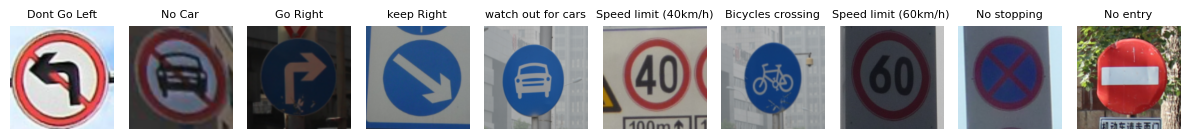

In [50]:
plotSample(img_ls)

# Feature Extraction #


Remove background using opencv's GrabCut

In [51]:
def graphSeg(img, x, y, w, h):
  mask = np.zeros(img.shape[:2], np.uint8)
  backgroundModel = np.zeros((1, 65), np.float64)
  foregroundModel = np.zeros((1, 65), np.float64)
  rectangle = (x, y, w, h)
  cv2.grabCut(img, mask, rectangle,backgroundModel,foregroundModel,5, cv2.GC_INIT_WITH_RECT)
  mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
  img = img * mask2[:, :, np.newaxis]
  return img

In [52]:
for i in range(len(img_ls)):
  img_ls[i] = graphSeg(img_ls[i],25,25,215,215)

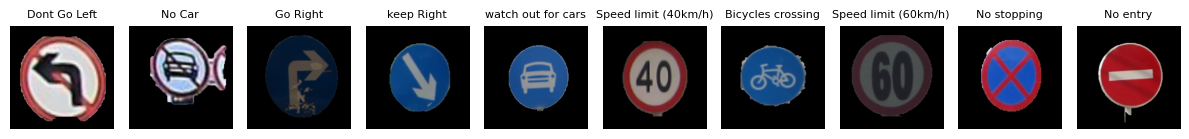

In [61]:
plotSample(img_ls)

## Histogram ##


In [53]:
hist_features_ls = np.zeros(shape=(len(img_ls), 3, 255, 1))

In [54]:
def calcAllHist(img):
    hist_features = np.zeros(shape=(3,255, 1))
    r_hist = cv2.calcHist([img], [0], None, [255], [1, 256])
    g_hist = cv2.calcHist([img], [1], None, [255], [1, 256])
    b_hist = cv2.calcHist([img], [2], None, [255], [1, 256])
    r_hist, g_hist, b_hist = r_hist/r_hist.sum(), g_hist/g_hist.sum(), b_hist/b_hist.sum()
    hist_features[0] = r_hist
    hist_features[1] = g_hist
    hist_features[2] = b_hist
    return hist_features

In [55]:
for i, img in enumerate(img_ls):
    hist_features_ls[i] = calcAllHist(img)

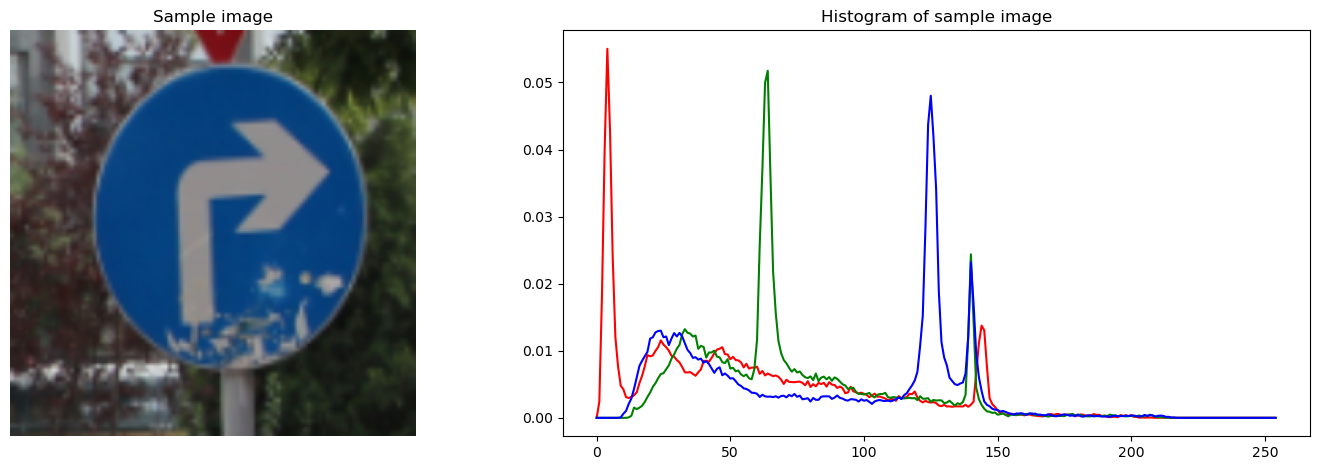

In [27]:
rand_index = random.randrange(0, len(img_ls), 1)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
ax1.imshow(img_ls[rand_index])
ax1.axis("off")
ax1.title.set_text("Sample image")
ax2.plot(hist_features_ls[rand_index][0], color="red")
ax2.plot(hist_features_ls[rand_index][1], color ="green")
ax2.plot(hist_features_ls[rand_index][2], color="blue")
ax2.title.set_text("Histogram of sample image")
fig.tight_layout()
# fig.savefig("./figs/histogram")


## Canny filter ##

In [31]:
canny_features_ls = np.zeros(shape=(len(img_ls), 256, 256))

In [32]:
def cannyFilter(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    filtered_img = cv2.Canny(gray_img, 100, 200)
    return filtered_img

In [95]:
for i, img in enumerate(img_ls):
    canny_features_ls[i] = cannyFilter(img)

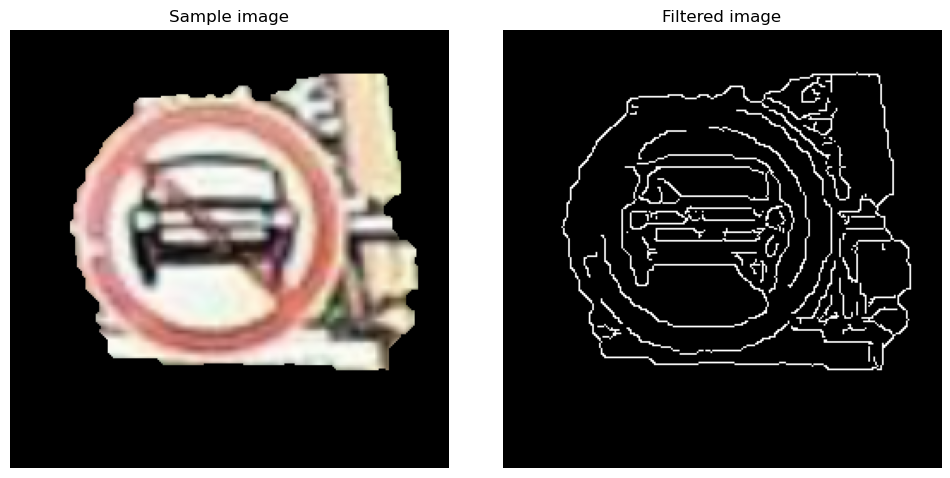

In [96]:
rand_index = random.randrange(0, len(img_ls), 1)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
ax1.imshow(img_ls[rand_index])
ax1.axis("off")
ax1.title.set_text("Sample image")
ax2.imshow(canny_features_ls[rand_index], cmap='gray')
ax2.axis("off")
ax2.title.set_text("Filtered image")
fig.tight_layout()
fig.savefig("./figs/canny")

## HOG ##


In [28]:
hog_features_ls = np.zeros(shape=(len(img_ls), 34596))

In [29]:
def computeHOG(img):
  gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  hog_feature = hog(gray_img, orientations=9,
                                pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                                block_norm='L2-Hys', transform_sqrt=True)
  return hog_feature

In [37]:
for i, img in enumerate(img_ls):
  hog_features_ls[i]  = computeHOG(img)

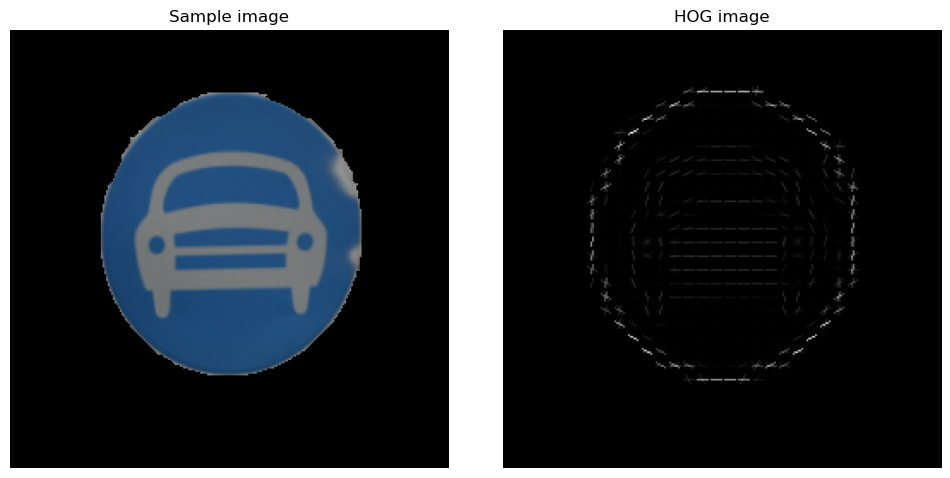

In [51]:
rand_index = random.randrange(0, len(img_ls), 1)
gray_img = cv2.cvtColor(img_ls[rand_index], cv2.COLOR_RGB2GRAY)
hog_feature, hog_image = hog(gray_img, orientations=9,
                                pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                                block_norm='L2-Hys', visualize=True, transform_sqrt=True)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
ax1.imshow(img_ls[rand_index])
ax1.axis("off")
ax1.title.set_text("Sample image")
ax2.imshow(hog_image, cmap='gray')
ax2.axis("off")
ax2.title.set_text("HOG image")
fig.tight_layout()
fig.savefig("./figs/HOG")

# ML Model Training #

In [103]:
knn = KNeighborsClassifier()
rf = RandomForestClassifier()

In [136]:
cv = KFold(n_splits=5)

In [137]:
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
grid_knn = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
grid_search_knn = GridSearchCV(estimator=knn, param_grid=grid_knn, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

In [138]:
n_estimators = [10, 100, 1000]
max_depth = [int(x) for x in np.linspace(10, 100, num = 4)]
max_features = ['sqrt', 'log2']
grid_rf = dict(n_estimators=n_estimators, max_depth=max_depth,max_features=max_features)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=grid_rf, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

### Histogram ###

In [139]:
X_hist_flattened = hist_features_ls.reshape(hist_features_ls.shape[0], -1)

print("Flattened data = ", X_hist_flattened.shape,  y.shape)

Flattened data =  (1387, 765) (1387,)


#### KNN with histogram


In [140]:
grid_knn_result_hist = grid_search_knn.fit(X_hist_flattened, y)

In [141]:
print("Best: %f using %s" % (grid_knn_result_hist.best_score_, grid_knn_result_hist.best_params_))
means = grid_knn_result_hist.cv_results_['mean_test_score']
stds = grid_knn_result_hist.cv_results_['std_test_score']
params = grid_knn_result_hist.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.267548 using {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
0.245228 (0.099786) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.245228 (0.099786) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
0.157988 (0.137467) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.196221 (0.122611) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.134873 (0.121245) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.186822 (0.126236) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.123331 (0.108810) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
0.185367 (0.128933) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
0.125476 (0.108086) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
0.183209 (0.128192) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
0.115404 (

In [143]:
joblib.dump(grid_knn_result_hist.best_estimator_, "./models/best_knn_hist.pkl", compress = 3)

['./models/best_knn_hist.pkl']

#### Random Forest with histogram

In [144]:
grid_rf_result_hist = grid_search_rf.fit(X_hist_flattened, y)

In [145]:
print("Best: %f using %s" % (grid_rf_result_hist.best_score_, grid_rf_result_hist.best_params_))
means = grid_rf_result_hist.cv_results_['mean_test_score']
stds = grid_rf_result_hist.cv_results_['std_test_score']
params = grid_rf_result_hist.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.232964 using {'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 10}
0.199133 (0.123105) with: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 10}
0.210667 (0.117759) with: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
0.215004 (0.124583) with: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 1000}
0.196229 (0.102664) with: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 10}
0.217897 (0.126141) with: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}
0.212129 (0.126949) with: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 1000}
0.221471 (0.113904) with: {'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 10}
0.230852 (0.116490) with: {'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 100}
0.230122 (0.113899) with: {'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 1000}
0.214259 (0.113827) with: {'max_depth': 40, 'max_features': 'log2', 'n_estimators': 10}
0.223645 (0.118917) with: {

In [146]:
joblib.dump(grid_rf_result_hist.best_estimator_, "./models/best_rf_hist.pkl", compress = 3)

['./models/best_rf_hist.pkl']

### Canny

In [1]:
X_canny_flattened = canny_features_ls.reshape(canny_features_ls.shape[0], -1)

print("Flattened data = ", X_canny_flattened.shape,  y.shape)

NameError: name 'canny_features_ls' is not defined

#### KNN with Canny

In [64]:
grid_knn_result_canny = grid_search_knn.fit(X_canny_flattened, y)

In [65]:
print("Best: %f using %s" % (grid_knn_result_canny.best_score_, grid_knn_result_canny.best_params_))
means = grid_knn_result_canny.cv_results_['mean_test_score']
stds = grid_knn_result_canny.cv_results_['std_test_score']
params = grid_knn_result_canny.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.877199 using {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.877199 (0.030920) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.877199 (0.030920) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}


In [ ]:
joblib.dump(grid_knn_result_canny.best_estimator_, "./models/best_knn_canny.pkl", compress = 3)

#### Random Forest wit Canny

In [ ]:
grid_rf_result_canny = grid_search_rf.fit(X_canny_flattened, y)

In [ ]:
print("Best: %f using %s" % (grid_rf_result_canny.best_score_, grid_rf_result_canny.best_params_))
means = grid_rf_result_canny.cv_results_['mean_test_score']
stds = grid_rf_result_canny.cv_results_['std_test_score']
params = grid_rf_result_canny.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
joblib.dump(grid_rf_result_canny.best_estimator_, "./models/best_rf_canny.pkl", compress = 3)

### HOG

In [52]:
X_hog_flattened = hog_features_ls
print("Flattened data = ", X_hog_flattened.shape,  y.shape)

Flattened data =  (1387, 34596) (1387,)


#### KNN with HOG

In [ ]:
grid_knn_result_hog = grid_search_knn.fit(X_hog_flattened, y)

In [ ]:
print("Best: %f using %s" % (grid_knn_result_hog.best_score_, grid_knn_result_hog.best_params_))
means = grid_knn_result_hog.cv_results_['mean_test_score']
stds = grid_knn_result_hog.cv_results_['std_test_score']
params = grid_knn_result_hog.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
joblib.dump(grid_knn_result_hog.best_estimator_, "./models/best_knn_hog.pkl", compress = 3)

#### Random Forest with HOG

In [ ]:
grid_rf_result_hog = grid_search_rf.fit(X_hog_flattened, y)

In [ ]:
print("Best: %f using %s" % (grid_rf_result_hog.best_score_, grid_rf_result_hog.best_params_))
means = grid_rf_result_hog.cv_results_['mean_test_score']
stds = grid_rf_result_hog.cv_results_['std_test_score']
params = grid_rf_result_hog.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
joblib.dump(grid_rf_result_hog.best_estimator_, "./models/best_rf_hog.pkl", compress = 3)

# Model Evaluation #

In [34]:
test_dir = base_dir + "TEST/"
test_img_ls = []
y_test = []
test_img_paths = []
for file_name in os.listdir(test_dir):
    # print(file_name)
    img_path = os.path.join(test_dir, file_name)
    test_img_paths.append(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    test_img_ls.append(img)
    y_test.append(file_name.split("_")[0].lstrip('0'))
y_test = le.transform(y_test)
print("Total test images: ", len(test_img_ls))
print(y_test)

Total test images:  400
[2 7 7 7 3 0 8 1 1 5 3 0 3 3 0 8 0 6 7 0 4 6 9 3 6 7 9 8 8 5 6 9 3 6 3 5 8
 4 9 3 8 7 7 4 9 2 8 3 6 8 4 1 2 6 7 9 3 0 2 5 0 1 0 7 8 7 8 3 6 0 2 6 8 5
 7 6 3 2 7 0 1 5 8 1 6 1 8 9 3 5 1 9 2 0 4 1 9 8 8 4 3 1 1 7 4 3 3 9 4 8 4
 4 3 0 8 8 6 1 5 6 5 4 5 6 4 8 0 1 7 7 3 0 3 1 7 1 7 5 1 3 2 9 2 8 3 8 4 3
 4 3 8 7 3 9 3 9 3 5 2 1 0 8 9 3 2 4 6 9 5 3 8 3 9 4 8 7 9 4 3 2 3 9 6 8 4
 0 9 4 4 3 3 8 4 2 0 9 3 0 4 9 0 4 3 5 7 7 4 0 2 2 8 0 3 5 0 7 0 6 5 5 1 0
 9 4 1 7 1 7 5 6 5 0 2 5 9 1 5 6 2 1 8 4 3 0 3 0 5 1 9 7 6 1 1 7 8 4 9 7 0
 1 4 2 5 8 6 3 7 5 6 5 7 9 3 1 9 4 5 8 8 7 0 5 0 0 7 5 1 8 5 6 0 0 8 3 4 3
 8 9 5 6 3 4 7 5 7 6 8 6 8 0 0 2 4 3 1 9 5 2 8 5 1 2 6 7 0 5 5 7 9 1 9 3 3
 5 4 7 7 3 3 5 9 7 1 1 6 3 8 4 8 1 7 1 3 8 9 3 4 8 4 8 9 9 9 2 6 9 8 5 5 6
 1 8 7 1 0 9 3 5 0 9 1 0 6 1 4 3 6 1 3 2 4 9 3 2 0 6 2 4 4 6]


In [35]:
for i in range(len(test_img_ls)):
  test_img_ls[i] = graphSeg(test_img_ls[i],25,25,215,215)

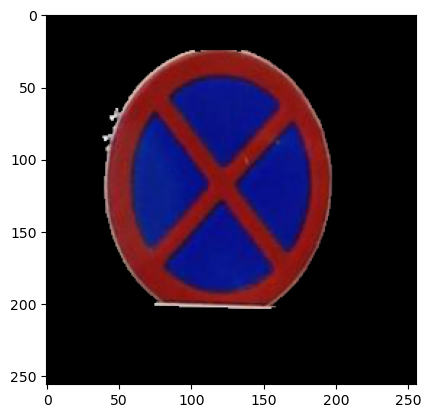

In [38]:
plt.imshow(test_img_ls[40])
# 351 411 631 617

In [148]:
best_knn_hist = joblib.load("./models/best_knn_hist.pkl")
best_knn_canny = joblib.load("./models/best_knn_canny.pkl")
best_knn_hog = joblib.load("./models/best_knn_hog.pkl")
best_rf_hist = joblib.load("./models/best_rf_hist.pkl")
best_rf_canny = joblib.load("./models/best_rf_canny.pkl")
best_rf_hog = joblib.load("./models/best_rf_hog.pkl")

In [40]:
test_hist_features_ls = np.zeros(shape=(len(test_img_ls), 3, 255, 1))
test_canny_features_ls = np.zeros(shape=(len(test_img_ls), 256, 256))
test_hog_features_ls = np.zeros(shape=(len(test_img_ls), 34596))

for i, img in enumerate(test_img_ls):
    test_hist_features_ls[i] = calcAllHist(img)
    test_canny_features_ls[i] = cannyFilter(img)
    test_hog_features_ls[i] = computeHOG(img)

In [44]:
X_test_hist_flattened = test_hist_features_ls.reshape(test_hist_features_ls.shape[0], -1)
X_test_canny_flattened = test_canny_features_ls.reshape(test_canny_features_ls.shape[0], -1)
X_test_hog_flattened = test_hog_features_ls

In [41]:
print(test_hist_features_ls.shape, test_canny_features_ls.shape, test_hog_features_ls.shape)

(400, 3, 255, 1) (400, 256, 256) (400, 34596)


In [149]:
best_knn_hist.score(X_test_hist_flattened, y_test)

0.35

In [72]:
best_rf_hog.score(X_test_hog_flattened, y_test)

0.905